<a href="https://colab.research.google.com/github/azmd801/back_order_prediction/blob/main/notebook/Data_transformation_%26_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Approcah for data transformation

There are lot of options availble for preprocessing data all these options are hyperparameters and can be cross validated to find the best preprocessing pipelin

### Fixed steps which will done initially before any data transformation
* dropping unncessary features  `'sku'`

### Diffrent pre-processing optiona availbale

1. use all the data as it is without any modification
2. Use winsorization to handle outlier
3. removing extreme sparse feature  `'in_transit_qty'`, `'local_bo_qty'`, `'pieces_past_due'`
4. Removing extreme imbalance features `'potential_issue'`, `'oe_constraint'`, and `'rev_stop`
5. Removing extreme sparse features

### Options for Handling categorical feature
1. Use one hot encode by removing first dummy variable
2.Keeping all the variabbles

### Options for imputation

 * `lead_time` has 100894 missing records (6%) which is large so these records cant be dropped
 * For rest of the features there is only one missing records so these will be dropped
 * For handiling the missing value of lead_time knn_imputer and median imputaion will be used
 * add_indicator will be explored

### Refrences

 * https://chinmaydalvi.medium.com/backorder-prediction-using-machine-learning-cbe2a7d2cfa4


## Importing required libraries

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings("ignore")

# intalling required libraries
!pip install --quiet  unrar
!pip install --quiet  patool
import os
import patoolib

!pip install --quiet optuna
import optuna

optuna.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00


'3.3.0'

## Custom functions and class

In [4]:

class CustomMLPipeline:
    """
    Custom Machine Learning Pipeline for Classification.

    This class provides tools for creating a tailored machine learning pipeline, designed to streamline the
    process of experimenting with different configurations and finding the optimal setup for classification tasks.

    Attributes:
    - imputer_type (str): Choose an imputation method for handling missing data.
    - drop_and_winsorize (bool): Enable dropping of columns and applying winsorization.
    - classifier (str): Select a classifier for training the model.
    - columns_to_drop (str): Specify columns to drop from the data.
    - add_indicator (bool): Indicate whether to add informative indicator columns.
    - keep_first (bool): Specify whether to retain the first category during encoding.

    Methods:
    - __init__(*args, add_indicator: bool = False, keep_first: bool = False):
        Initialize the custom classification pipeline.

    - _create_classifier() -> Classifier:
        Create and return an instance of the chosen classifier.

    - _drop_col(X: pd.DataFrame) -> pd.DataFrame:
        Drop specified columns from the input DataFrame.

    - create_pipeline() -> Pipeline:
        Construct and return a customized classification pipeline.

    By adjusting the parameters and options, you can systematically explore various approaches to preprocessing,
    classification, and feature engineering. This class empowers you to iterate and fine-tune your pipeline to
    discover the most effective way to teach your model to classify data.
    """
    # Common varaibles used for pipeline exprementation defined as  class-level attributes
    useless_cols = ['in_transit_qty', 'local_bo_qty', 'pieces_past_due',
                'potential_issue', 'oe_constraint', 'rev_stop']

    sparse_cols = ['in_transit_qty', 'forecast_3_month', 'forecast_6_month',
                  'forecast_9_month', 'sales_1_month', 'sales_3_month',
                  'sales_6_month', 'sales_9_month', 'min_bank',
                  'pieces_past_due', 'local_bo_qty']

    numeric_cols = ['national_inv', 'lead_time', 'in_transit_qty',
                    'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
                    'sales_1_month', 'sales_3_month', 'sales_6_month',
                    'sales_9_month', 'min_bank', 'pieces_past_due',
                    'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']

    cat_cols = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
                'stop_auto_buy', 'rev_stop']

    def __init__(self, imputer_type, drop_and_winsorize, classifier, columns_to_drop,
                 add_indicator=False, keep_first=False):
        """
        Initialize the custom classification pipeline.

        Parameters:
        - imputer_type (str): Type of imputation strategy for handling missing data.
        - drop_and_winsorize (bool): Flag indicating whether to drop columns and perform winsorization.
        - classifier (str): Type of classifier to be used for the pipeline.
        - columns_to_drop (str): Type of columns to be dropped from the dataset.
        - add_indicator (bool, optional): Include additional indicator columns after imputation. Default is False.
        - keep_first (bool, optional): Keep the first category during feature encoding. Default is False.
        """
        self.imputer_type = imputer_type
        self.drop_and_winsorize = drop_and_winsorize
        self.classifier = classifier
        self.columns_to_drop = columns_to_drop
        self.add_indicator = add_indicator
        self.keep_first = keep_first


        # Determine columns to drop based on configuration
        if self.drop_and_winsorize:
            self.drop_cols = self.useless_cols if self.columns_to_drop == 'useless' else self.sparse_cols
        else:
            self.drop_cols = []

        # Columns to be used in the pipeline
        self.num_cols_used = [col for col in self.numeric_cols if col not in self.drop_cols]
        self.cat_cols_used = [col for col in self.cat_cols if col not in self.drop_cols]

    def _create_classifier(self):
        """
        Create and return an instance of the chosen classifier.

        Returns:
        - clf: The chosen classifier instance.
        """
        if self.classifier == 'RandomForest':
            clf = RandomForestClassifier()

        elif self.classifier == 'SVC':
            clf = SVC()

        elif self.classifier == 'LogisticRegression':
            clf = LogisticRegression(solver='liblinear')

        elif self.classifier == 'XGBoost':
            clf = XGBClassifier()

        else:
            raise ValueError(f"Invalid classifier: {self.classifier}")

        return clf

    def _drop_col(self, X):
        """
        Drop specified columns from the input DataFrame.

        Parameters:
        - X (pd.DataFrame): Input DataFrame.

        Returns:
        - X_dropped (pd.DataFrame): DataFrame with specified columns removed.
        """
        if not self.drop_and_winsorize:
            # Always drop 'sku' column and additional columns specified in drop_cols
            X.drop('sku', axis=1)

        columns_to_drop = ['sku'] + self.drop_cols
        return X.drop(columns_to_drop, axis=1)

    def create_pipeline(self):
        """
        Construct and return a customized classification pipeline.

        Returns:
        - training_pipeline: A tailored pipeline for classification.
        """
        # Conditional creation of imputer based on 'imputer_type'
        if self.imputer_type == 'knn':
            imp = KNNImputer(weights='distance', add_indicator=self.add_indicator)
        else:
            imp = SimpleImputer(strategy='median', add_indicator=self.add_indicator)

        # Conditional initialization of cat_encoder based on 'keep_first'
        cat_encoder = OneHotEncoder(drop='first') if self.keep_first else OneHotEncoder()

        # Constructing the numerical pipeline
        num_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('imputer', imp),
            ('outlier_clipping', Winsorizer(change=self.drop_and_winsorize)),
        ])

        # Constructing the categorical pipeline
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehotencoder', cat_encoder),
        ])

        # Constructing the training pipeline
        clf = self._create_classifier()
        training_pipeline = Pipeline([
            ('Drop_Columns', FunctionTransformer(self._drop_col)),
            ('Balancing', RandomOverSampler()),
            ('Feature_transform', ColumnTransformer([
                ('num_pipeline', num_pipeline, self.num_cols_used),
                ('cat_pipeline', cat_pipeline, self.cat_cols_used),
            ])),
            ('model', clf)
        ])

        return training_pipeline

In [5]:
# Some functions for creating feature transformation pipeline

## function to drop columns

def drop_col(df: pd.DataFrame, columns: List[str], drop: bool =True) -> pd.DataFrame:
    """
    Drop columns from a DataFrame.

    Parameters:
    - df: Input DataFrame.
    - columns: List of column names to drop.

    Returns:
    - DataFrame: DataFrame with the specified columns dropped.
    """
    # if 'sku' in df.columns:
    #   df.drop('sku',inplace=True,axis=1)

    if not drop:
      return df.drop('sku',axis=1)

    return df.drop('sku',axis=1).drop(columns, axis=1)

from sklearn.base import TransformerMixin

## custom class with fit and tranform to perform winsorization

class Winsorizer(TransformerMixin):
    def __init__(self, change=True):
        """
        Initialize the Winsorizer transformer.

        Parameters:
        - lower_quantile (float): Lower quantile for winsorization (default: 0.05).
        - upper_quantile (float): Upper quantile for winsorization (default: 0.95).
        """
        self.change = change

    def fit(self, X, y=None):
        """
        Fit the Winsorizer transformer.

        Parameters:
        - X (array-like): Input data.
        - y: Ignored.

        Returns:
        - self: Returns the instance of the transformer.
        """
        # Calculate the percentiles
        p0 = np.nanpercentile(X, 0)
        p100 = np.nanpercentile(X, 100)

        # Calculate the lower and upper IQR
        Q1 = np.nanpercentile(X, 25)
        Q3 = np.nanpercentile(X, 75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds
        self.lower_bound = max(Q1 - (1.5 * IQR),p0)
        self.upper_bound = min(Q3 + (1.5 * IQR),p100)
        return self

    def transform(self, X):
        """
        Transform the input data using winsorization.

        Parameters:
        - X (array-like): Input data to be transformed.

        Returns:
        - X_transformed (array-like): Transformed data after winsorization.
        """

        if not self.change:
          return X

        X_clipped = np.clip(X, self.lower_bound, self.upper_bound)
        return X_clipped

    def get_feature_names_out(self, input_features):
        """
        Get the feature names after transformation.

        Parameters:
        - input_features (array-like): Input feature names.

        Returns:
        - output_features (array-like): Transformed feature names.
        """
        return input_features

# Data Ingestion

In [6]:

# Create a directory to store the dataset
if not os.path.exists("dataset"):
    os.makedirs("dataset")

# Download the RAR file from GitHub
!wget -O dataset/dataset.rar https://github.com/rodrigosantis1/backorder_prediction/raw/master/dataset.rar

# Extract the RAR file
patoolib.extract_archive("dataset/dataset.rar", outdir="dataset")

--2023-08-29 11:17:48--  https://github.com/rodrigosantis1/backorder_prediction/raw/master/dataset.rar
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rodrigosantis1/backorder_prediction/master/dataset.rar [following]
--2023-08-29 11:17:49--  https://raw.githubusercontent.com/rodrigosantis1/backorder_prediction/master/dataset.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24741696 (24M) [application/octet-stream]
Saving to: ‘dataset/dataset.rar’

dataset/dataset.rar 100%[===================>]  23.59M  --.-KB/s    in 0.1s    

2023-08-29 11:18:34 (211 MB/s) - ‘dataset/dataset.rar’ saved [247

'dataset'

In [7]:
# reading th data
raw_data = pd.read_csv(r"/content/dataset/Kaggle_Training_Dataset_v2.csv")
raw_data.shape

(1687861, 23)

In [8]:
raw_data

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,...,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No


# Data cleaning

In [9]:
# dropping the na record for all the features except for feature 'lead_time'

print(f"Shape of data before dropping na {raw_data.shape}\n")
raw_data.dropna(subset=raw_data.columns.drop('lead_time'),inplace=True)
print(f"Shape of data after dropping na {raw_data.shape}\n")

Shape of data before dropping na (1687861, 23)

Shape of data after dropping na (1687860, 23)



# Expermentin with different ML training pipeline using optuna   

## Preparing required Variables for optimizing the objective function

In [10]:
raw_data.dtypes

sku                   object
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
potential_issue       object
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

In [ ]:
# Take 10000 random samples from the dataset while stratifying based on a specific column (e.g., 'label')
# sample_size = 100000
# samples = raw_data.sample(n=sample_size, replace=False)
# samples.head()

# # spliting X_train and y_train
# y_train = LabelEncoder().fit_transform(samples['went_on_backorder'])
# X_train = samples.drop('went_on_backorder',axis=1)

# print(X_train.shape)
# print(y_train.shape)

(100000, 22)
(100000,)


In [11]:
# spliting X_train and y_train
y_train = LabelEncoder().fit_transform(raw_data['went_on_backorder'])
X_train = raw_data.drop('went_on_backorder',axis=1)

print(X_train.shape)
print(y_train.shape)

(1687860, 22)
(1687860,)


In [12]:
y_train

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
# # segregating numeric and categorical fetaure
# numeric_cols = X_train.columns[X_train.dtypes != 'object']
# print(f'Numeric columns: {numeric_cols}\n')

# cat_cols = X_train.columns[X_train.dtypes == 'object'].drop('sku')
# print(f'Categorical columns: {cat_cols}\n')

# print(f'Target columns : went_on_backorder')

In [10]:
# useless_cols = ['in_transit_qty', 'local_bo_qty', 'pieces_past_due','potential_issue', 'oe_constraint','rev_stop']

In [ ]:
# # Calculate the proportion of zeros in each column
# zero_proportion = (X_train == 0).sum() / len(X_train)

# # Filter features with more than 30 percent zeros
# threshold = 0.3
# filtered_data = X_train.drop(columns=zero_proportion[zero_proportion < threshold].index)

# # Get the feature names of the remaining columns
# sparse_cols = filtered_data.columns.tolist()

# print(sparse_cols)

In [13]:
# class MLPipeline:
#     def __init__(self, imputer_type, drop_and_winsorize, classifier, columns_to_drop,
#                  add_indicator=False, keep_first=False):

#         self.imputer_type = imputer_type
#         self.drop_and_winsorize = drop_and_winsorize
#         self.classifier = classifier
#         self.columns_to_drop = columns_to_drop
#         self.useless_cols = useless_cols
#         self.sparse_cols = sparse_cols
#         self.numeric_cols = numeric_cols
#         self.cat_cols = cat_cols
#         self.add_indicator = add_indicator
#         self.keep_first = keep_first

#         if self.drop_and_winsorize:
#             self.drop_cols = self.useless_cols if self.columns_to_drop == 'useless' else self.sparse_cols
#         else:
#             self.drop_cols = []

#         self.num_cols_used = [col for col in self.numeric_cols if col not in self.drop_cols]
#         self.cat_cols_used = [col for col in self.cat_cols if col not in self.drop_cols]

#     def _create_classifier(self):
#         if self.classifier == 'RandomForest':
#             clf = RandomForestClassifier()

#         elif self.classifier == 'SVC':
#             clf = SVC()

#         elif self.classifier == 'LogisticRegression':
#             clf = LogisticRegression(solver='liblinear')

#         elif self.classifier == 'XGBoost':
#             clf = XGBClassifier()

#         else:
#             raise ValueError(f"Invalid classifier: {self.classifier}")

#         return clf

#     def _drop_col(self, X):
#         if not self.drop_and_winsorize:
#           # Always drop 'sku' column and additional columns specified in drop_cols
#             X.drop('sku',axis=1)

#         columns_to_drop = ['sku'] + self.drop_cols
#         return X.drop(columns_to_drop, axis=1)

#     def create_pipeline(self):
#         # Conditional creation of imputer based on 'imputer_type'
#         if self.imputer_type == 'knn':
#             imp = KNNImputer(weights='distance', add_indicator=self.add_indicator)
#         else:
#             imp = SimpleImputer(strategy='median', add_indicator=self.add_indicator)

#         # Conditional initialization of cat_encoder based on 'keep_first'
#         cat_encoder = OneHotEncoder(drop='first') if self.keep_first else OneHotEncoder()

#         # Constructing the numerical pipeline
#         num_pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('imputer', imp),
#             ('outlier_clipping', Winsorizer(change=self.drop_and_winsorize)),
#         ])

#         # Constructing the categorical pipeline
#         cat_pipeline = Pipeline([
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('onehotencoder', cat_encoder),
#         ])

#         # Constructing the training pipeline
#         clf = self._create_classifier()
#         training_pipeline = Pipeline([
#             ('Drop_Columns', FunctionTransformer(self._drop_col)),
#             ('Balancing', RandomOverSampler()),
#             ('Feature_transform', ColumnTransformer([
#                 ('num_pipeline', num_pipeline, self.num_cols_used),
#                 ('cat_pipeline', cat_pipeline, self.cat_cols_used),
#             ])),
#             ('model', clf)
#         ])

#         return training_pipeline

In [13]:
# Split the data into train and validation sets (80% train, 20% validation)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (1012716, 22)
Shape of y_train: (1012716,)
Shape of X_val: (675144, 22)
Shape of y_val: (675144,)


## ML pipeline Selection

In [10]:
# Defining Objective function which will be optimized

def objective(trial):

    # Sampling the classifiers
    classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC', 'LogisticRegression', 'XGBoost'])

    # experimenting with dropping unnecessary columns and outlier handling
    drop_and_winsorize = trial.suggest_int('drop_and_winsorize',0,1)

    # experimenting with columns to drop
    columns_to_drop = trial.suggest_categorical('columns_to_drop', ['useless', 'sparse'])

    # experimenting with imputers
    add_indicator = trial.suggest_int('add_indicator',0,1)
    imputer = trial.suggest_categorical('imputer_type',['simple','knn'])

    # experimenting with one hot encoding
    keep_first = trial.suggest_int('keep_first',0,1)

    pipeline_params = {
    'imputer_type': imputer,
    'drop_and_winsorize': drop_and_winsorize,
    'classifier': classifier,
    'columns_to_drop': columns_to_drop,
    'add_indicator': add_indicator,
    'keep_first': keep_first
    }
    pipeline = MLPipeline(**pipeline_params)

   # constructing training pipeline
    training_pipeline = pipeline.create_pipeline()

    training_pipeline.fit(X_train,y_train)

    scores = balanced_accuracy_score(y_val, training_pipeline.predict(X_val))
    # scorer = make_scorer(balanced_accuracy_score)

    # scores = cross_val_score(training_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring=scorer)
    # report_cross_validation_scores(trial, scores)

    # Returning the cross-validated mean score
    return scores.mean()


In [ ]:
study = optuna.create_study(direction="maximize")
# terminator = TerminatorCallback()
study.optimize(objective, n_trials=100, n_jobs=-1, )#, #callbacks=[terminator])
trial = study.best_trial

print('f1_score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

* Due to lack of resuurces we find the best pilpiline using 100000 snamples (10% of whole data)

* Optuna giving a pipeline having Logistincregressin as eatimator due to such s sample size we dont have confidence in the model

* We will perform cross validation to find the best hypermaters of multiple models of using transformation obtained from best piple using whole data

## Model Selection

In [ ]:
# Best pipeline parameters obtained from cross validation using optuna
best_pipeline_param = {
    'classifier': 'LogisticRegression',
    'drop_and_winsorize': 1,
    'columns_to_drop': 'useless',
    'add_indicator': 1,
    'imputer_type': 'simple',
    'keep_first': 1
}

# Creating the best MLPipeline with the best hyperparameters
best_ml_pipeline = MLPipeline(**best_pipeline_param).create_pipeline()

# Lists to store train and validation scores for each classifier
train_score_list = []
val_score_list = []

# List of classifiers to evaluate
clf_list = [XGBClassifier(), RandomForestClassifier(), LogisticRegression(), SVC()]

for clf in clf_list:
    # Updating the classifier in the pipeline
    best_ml_pipeline.steps[-1] = ('model', clf)

    # Fitting the pipeline to the training data
    best_ml_pipeline.fit(X_train, y_train)

    # Evaluating the train score and storing it
    train_score = balanced_accuracy_score(y_train, best_ml_pipeline.predict(X_train))
    train_score_list.append(train_score)

    # Evaluating the validation score and storing it
    val_score = balanced_accuracy_score(y_val, best_ml_pipeline.predict(X_val))
    val_score_list.append(val_score)

    # Printing the train and validation scores for the current classifier
    print(f"""
    For model {clf}:
        Train score = {train_score}
        Validation score = {val_score}
    """)

* XGboost is gving the best performance using the best pipline obtained
* Now we will find best hyper parameters XGboost to further improve the performance

## Hyperparameter tuning of the best model

In [ ]:
# creating objective function to find the besst hyperparameter

def objective_hp_tuning(trial):

  # Best pipeline parameters obtained from cross validation using optuna
  best_pipeline_param = {
      'classifier': 'XGBoost',
      'drop_and_winsorize': 1,
      'columns_to_drop': 'useless',
      'add_indicator': 1,
      'imputer_type': 'simple',
      'keep_first': 1
  }

  # Creating the best MLPipeline
  best_ml_pipeline = MLPipeline(**best_pipeline_param).create_pipeline()

  # Sampling hyperparameters for XGBoostClassifier
  n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300, step=50)
  max_depth = trial.suggest_int('xgb_max_depth', 1, 10)
  learning_rate = trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.1)
  subsample = trial.suggest_uniform('xgb_subsample', 0.6, 0.9)

  # putting the hyperparameter in kwarg args
  hyperparams = {
    'model__n_estimators': n_estimators,
    'model__max_depth': max_depth,
    'model__learning_rate': learning_rate,
    'model__subsample': subsample
  }

  # passing the hyperparameters to the estimator
  best_ml_pipeline.set_params(**hyperparams)

  # Fitting the pipeline to the training data
  best_ml_pipeline.fit(X_train, y_train)

  # Evaluating the validation score
  val_score = balanced_accuracy_score(y_val, best_ml_pipeline.predict(X_val))

  return val_score


In [ ]:
# Create an Optuna study object for hyperparameter tuning with "maximize" direction to maximize the objective function
study = optuna.create_study(direction="maximize")

# Perform hyperparameter tuning using the objective_hp_tuning function as the objective function
# n_trials: Number of trials (iterations) for hyperparameter tuning
# n_jobs: Number of parallel jobs to run in parallel. Use -1 to use all available CPU cores.
study.optimize(objective_hp_tuning, n_trials=100, n_jobs=-1)

# Get the best trial from the study (the trial with the highest value of the objective function)
trial = study.best_trial

# Print the balanced score obtained from the best trial
print('balanced score: {}'.format(trial.value))

# Print the best hyperparameters found from the hyperparameter tuning process
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-05 06:24:03,589] A new study created in memory with name: no-name-c22358fd-fc26-4f9a-95e9-11158f8fa3d1
[I 2023-08-05 06:27:30,060] Trial 1 finished with value: 0.853263642375435 and parameters: {'xgb_n_estimators': 50, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.07026723290192255, 'xgb_subsample': 0.8594545021190145}. Best is trial 1 with value: 0.853263642375435.
[I 2023-08-05 06:38:46,802] Trial 2 finished with value: 0.8591545831490622 and parameters: {'xgb_n_estimators': 200, 'xgb_max_depth': 2, 'xgb_learning_rate': 0.025178702998072428, 'xgb_subsample': 0.7432464552214986}. Best is trial 2 with value: 0.8591545831490622.
[I 2023-08-05 06:58:14,994] Trial 0 finished with value: 0.8886249601343184 and parameters: {'xgb_n_estimators': 100, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.02251088885825726, 'xgb_subsample': 0.6344097333650928}. Best is trial 0 with value: 0.8886249601343184.
[I 2023-08-05 07:21:20,897] Trial 3 finished with value: 0.883111317111936 and parameters

# Model training

In [12]:
# parmas for best ml pipeline
best_pipeline_param = {
    'classifier': 'XGBoost',
    'drop_and_winsorize': 1,
    'columns_to_drop': 'useless',
    'add_indicator': 1,
    'imputer_type': 'simple',
    'keep_first': 1
}
# creating the comple pipeline
best_ml_pipeline = CustomMLPipeline(**best_pipeline_param).create_pipeline()

# hyperparameters
model_hyperparams = {
    'model__n_estimators': 250,
    'model__max_depth': 7,
    'model__learning_rate': 0.06038443608301605,
    'model__subsample': 0.7669681486745225
}
# passing the hyperparameters to estimator of pipeline
best_ml_pipeline.set_params(**model_hyperparams)

# training begins
print('training begins')
best_ml_pipeline.fit(X_train,y_train)
print('training finished')

training begins
training finished


In [13]:
# Save the pipeline as a pickle file
import pickle
with open('ml_pipeline.pkl', 'wb') as file:
    pickle.dump(best_ml_pipeline, file)

# Threshlod tuning using validation set and roc auc curve
* We checked diffferent performance metric using best trained pipeline and validation set
* Our target is to increase increase TPR and decrease FPR.
* So we will find best threshold using ROC AUC cure which will give optimum values of TPR and FPR

In [14]:
# loading the trained pipline pickle
import pickle

# Load the trained pipeline from the pickle file
with open('ml_pipeline .pkl', 'rb') as file:
    best_ml_pipeline = pickle.load(file)

## Printing performace metric using default threshold

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tabulate import tabulate
from sklearn.model_selection import train_test_split

def generate_evaluation_report(y_train_pred , y_train_pred_proba, y_val_pred, y_val_pred_proba):
    performance_metric = [balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score]
    report = []

    for metric in performance_metric:
        if metric == roc_auc_score:
            train_score = metric(y_train, y_train_pred_proba)
            val_score = metric(y_val, y_val_pred_proba)
        else:
            train_score = metric(y_train, y_train_pred)
            val_score = metric(y_val, y_val_pred)

        report.append([metric.__name__, f'{train_score:.2f}', f'{val_score:.2f}'])

    report_table = tabulate(report, headers=["Metric", "Train Score", "Validation Score"], tablefmt="pretty")
    print('Model evalution report:\n')
    print(report_table)

    conf_matrix = confusion_matrix(y_val, y_val_pred, normalize='true') * 100

    headers = ["", "Predicted Negative", "Predicted Positive"]
    rows = [
        ["Actual Negative", f"TNR = {conf_matrix[0][0]:.2f}", f"FPR = {conf_matrix[0][1]:.2f}"],
        ["Actual Positive", f"FNR = {conf_matrix[1][0]:.2f}", f"TPR = {conf_matrix[1][1]:.2f}"]
    ]

    # Print confusion matrix in tabular format
    print('\nValidation Confusion matrix:\n')
    print(tabulate(rows, headers=headers, tablefmt="pretty"))

In [17]:
y_train_pred = best_ml_pipeline.predict(X_train)
y_train_pred_proba = best_ml_pipeline.predict_proba(X_train)[:, 1]
y_val_pred = best_ml_pipeline.predict(X_val)
y_val_pred_proba = best_ml_pipeline.predict_proba(X_val)[:, 1]

generate_evaluation_report(y_train_pred , y_train_pred_proba, y_val_pred, y_val_pred_proba)

Model evalution report:

+-------------------------+-------------+------------------+
|         Metric          | Train Score | Validation Score |
+-------------------------+-------------+------------------+
| balanced_accuracy_score |    0.93     |       0.89       |
|      roc_auc_score      |    0.98     |       0.96       |
|     precision_score     |    0.06     |       0.06       |
|      recall_score       |    0.96     |       0.88       |
|        f1_score         |    0.12     |       0.11       |
+-------------------------+-------------+------------------+

Validation Confusion matrix:

+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |    TNR = 90.39     |     FPR = 9.61     |
| Actual Positive |    FNR = 12.01     |    TPR = 87.99     |
+-----------------+--------------------+--------------------+


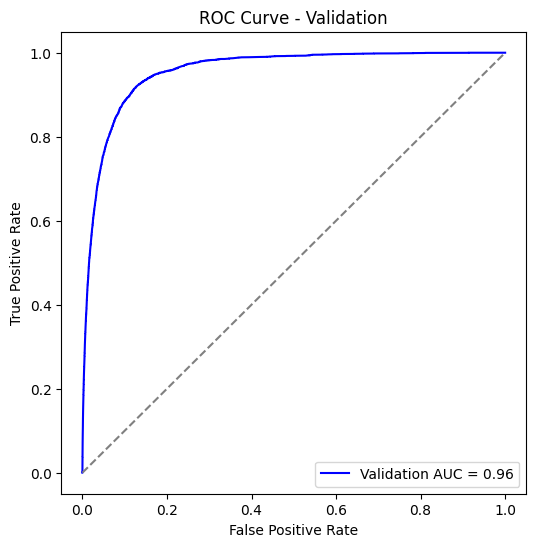

In [32]:
def plot_roc_curve(X_val, y_val, ml_pipeline):
    y_val_pred_proba = ml_pipeline.predict_proba(X_val)[:, 1]

    fpr_val, tpr_val, threshold = roc_curve(y_val, y_val_pred_proba)
    auc_val = auc(fpr_val, tpr_val)

    # Plot ROC AUC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr_val, tpr_val, color='blue', label=f'Validation AUC = {auc_val:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Validation')
    plt.legend()
    plt.show()

    return tpr_val, fpr_val, threshold

# Call the function with your data and model
tpr, fpr, threshold = plot_roc_curve(X_val, y_val, best_ml_pipeline)

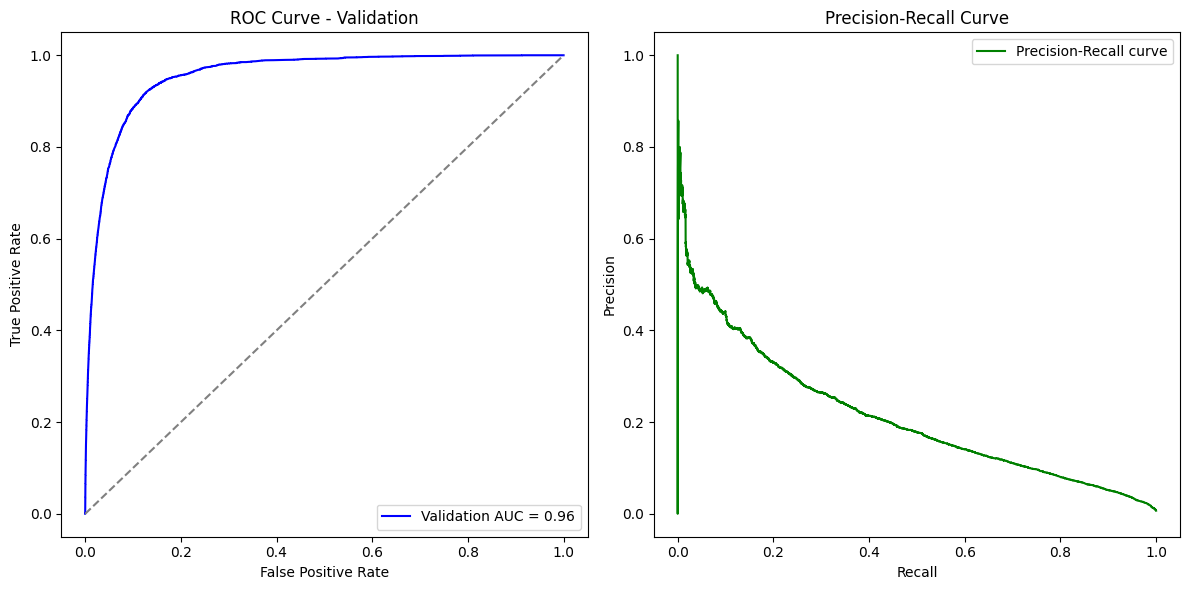

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_pr_curves(y_val_pred_proba, y_val, ml_pipeline):
    # y_val_pred_proba = ml_pipeline.predict_proba(X_val)[:, 1]

    # ROC Curve
    fpr_val, tpr_val, threshold_roc = roc_curve(y_val, y_val_pred_proba)
    auc_val = auc(fpr_val, tpr_val)

    # Precision-Recall Curve
    precision_val, recall_val, threshold_pr = precision_recall_curve(y_val, y_val_pred_proba)

    # Plot ROC AUC curve
    plt.figure(figsize=(12, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr_val, tpr_val, color='blue', label=f'Validation AUC = {auc_val:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Validation')
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_val, precision_val, color='green', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return precision_val, recall_val, threshold_pr

# Call the function with your data and model
precision, recall, threshold = plot_roc_pr_curves(y_val_pred_proba, y_val, best_ml_pipeline)

## Threshold tuning

In [39]:
(precision + recall)

array([1.00676004, 1.00676006, 1.00676007, ..., 0.50021911, 0.        ,
       1.        ])

In [45]:
f1 = ((2 * precision * recall)/(precision + recall))[:-2]

In [47]:
best_t

0.94668883

In [46]:
best_t = threshold[np.argmax(f1)]

In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score

# proba_score = best_ml_pipeline.predict_proba(X_val)[:, 1]

# f1_score_list = [f1_score(y_val, (proba_score >= th).astype(int)) for th in threshold]

# best_threshold = threshold[np.argmax(f1_score_list)]
# y_val_pred = (proba_score >= best_threshold).astype(int)

In [ ]:
# f1_score_list = []
# proba_score = best_ml_pipeline.predict_proba(X_val)[:, 1]
# for th in threshold:
#   y = (proba_score >= th).astype(int)
#   f1_score_list.append(f1_score(y_val,y))

# best_threshold = threshold(np.armax())

In [48]:
proba_score = best_ml_pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (proba_score >= best_t).astype(int)

In [49]:
y_val_pred

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
precision_score(y_val,y_val_pred)*100

25.389830508474574

In [51]:
generate_evaluation_report(y_train_pred , y_train_pred_proba, y_val_pred, y_val_pred_proba)

Model evalution report:

+-------------------------+-------------+------------------+
|         Metric          | Train Score | Validation Score |
+-------------------------+-------------+------------------+
| balanced_accuracy_score |    0.93     |       0.66       |
|      roc_auc_score      |    0.98     |       0.96       |
|     precision_score     |    0.06     |       0.25       |
|      recall_score       |    0.96     |       0.33       |
|        f1_score         |    0.12     |       0.29       |
+-------------------------+-------------+------------------+

Validation Confusion matrix:

+-----------------+--------------------+--------------------+
|                 | Predicted Negative | Predicted Positive |
+-----------------+--------------------+--------------------+
| Actual Negative |    TNR = 99.34     |     FPR = 0.66     |
| Actual Positive |    FNR = 67.18     |    TPR = 32.82     |
+-----------------+--------------------+--------------------+


In [ ]:
# # Defining Objective function which will be optimized

# def objective(trial):

#     # Sampling the classifier type along with its parameter
#     classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC', 'LogisticRegression', 'XGBoost'])

#     if classifier == 'RandomForest':
#         # Sampling hyperparameters for RandomForestClassifier
#         n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
#         max_depth = trial.suggest_int('max_depth', 5, 20)
#         min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#         min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

#         clf = RandomForestClassifier(
#             n_estimators=n_estimators,
#             max_depth=max_depth,
#             min_samples_split=min_samples_split,
#             min_samples_leaf=min_samples_leaf
#         )

#     elif classifier == 'SVC':
#         # Sampling hyperparameters for SVC
#         C = trial.suggest_loguniform('svc_C', 1e-3, 1e3)
#         kernel = trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
#         gamma = trial.suggest_categorical('svc_gamma', ['scale', 'auto'])

#         clf = SVC(C=C, kernel=kernel, gamma=gamma)

#     elif classifier == 'LogisticRegression':
#         # Sampling hyperparameters for LogisticRegression
#         C = trial.suggest_loguniform('lr_C', 1e-3, 1e3)
#         penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2'])

#         clf = LogisticRegression(C=C, penalty=penalty, solver='liblinear')

#     elif classifier == 'XGBoost':
#         # Sampling hyperparameters for XGBoostClassifier
#         n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300, step=50)
#         max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
#         learning_rate = trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.1)
#         subsample = trial.suggest_uniform('xgb_subsample', 0.6, 0.9)

#         clf = XGBClassifier(
#             n_estimators=n_estimators,
#             max_depth=max_depth,
#             learning_rate=learning_rate,
#             subsample=subsample
#         )

#     # experimenting with dropping unnecessary columns and outlier handling
#     drop_and_winsorize = trial.suggest_int('drop_and_winsorize',0,1)

#     if drop_and_winsorize:
#       # experimenting with columns to drop
#       columns_to_drop = trial.suggest_categorical('columns_to_drop', ['useless', 'sparse'])
#       drop_cols = useless_cols if columns_to_drop=='useless' else sparse_cols
#       num_cols_used = [col for col in numeric_cols if col not in drop_cols]
#       cat_cols_used = [col for col in cat_cols if col not in drop_cols]
#     else:
#       drop_cols, num_cols_used, cat_cols_used = [], [], []

#     # experimenting with imputers
#     add_indicator = trial.suggest_int('add_indicator',0,1)
#     imputer = trial.suggest_categorical('imputer',['simple','knn'])

#     if imputer == 'knn':
#       imp = KNNImputer(weights='distance', add_indicator=add_indicator)
#     else:
#       imp = SimpleImputer(strategy='median', add_indicator=add_indicator)

#     # experimenting with one hot encoding
#     keep_first = trial.suggest_int('keep_first',0,1)
#     cat_encoder = OneHotEncoder(drop='first') if keep_first else OneHotEncoder()

#     # Constructing the numerical pipeline
#     num_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('imputer', imp),
#         ('outlier_clipping', Winsorizer(change=drop_and_winsorize)),
#     ])
#     # constructing categorical pipeline
#     cat_pipeline = Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehotencoder', cat_encoder),
#     ])

#     # constructing training pipeline
#     training_pipeline = Pipeline([
#         ('Drop_Columns', FunctionTransformer(drop_col, kw_args={'columns': drop_cols, 'drop': drop_and_winsorize})),
#         ('Balancing', RandomOverSampler()),
#         ('Feature_transform', ColumnTransformer([
#             ('num_pipeline', num_pipeline, num_cols_used),
#             ('cat_pipeline', cat_pipeline, cat_cols_used),
#             ])),

#     ('Model training', clf)
#     ])

#     scorer = make_scorer(f1_score)

#     scores = cross_val_score(training_pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring=scorer)
#     # report_cross_validation_scores(trial, scores)

#     # Returning the cross-validated mean score
#     return scores.mean()


In [ ]:
# study = optuna.create_study(direction="maximize")
# # terminator = TerminatorCallback()
# study.optimize(objective, n_trials=100, n_jobs=2, )#, #callbacks=[terminator])
# trial = study.best_trial

# print('f1_score: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))
